<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2466694903.py:11: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=cols)


Dataset Loaded. Shape: (20631, 26)
First 5 rows:
   unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1        1            2     0.0019    -0.0003      100.0  518.67  642.15   
2        1            3    -0.0043     0.0003      100.0  518.67  642.35   
3        1            4     0.0007     0.0000      100.0  518.67  642.35   
4        1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

   s_18

/tmp/ipython-input-2466694903.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('unit_nr').apply(add_rul)


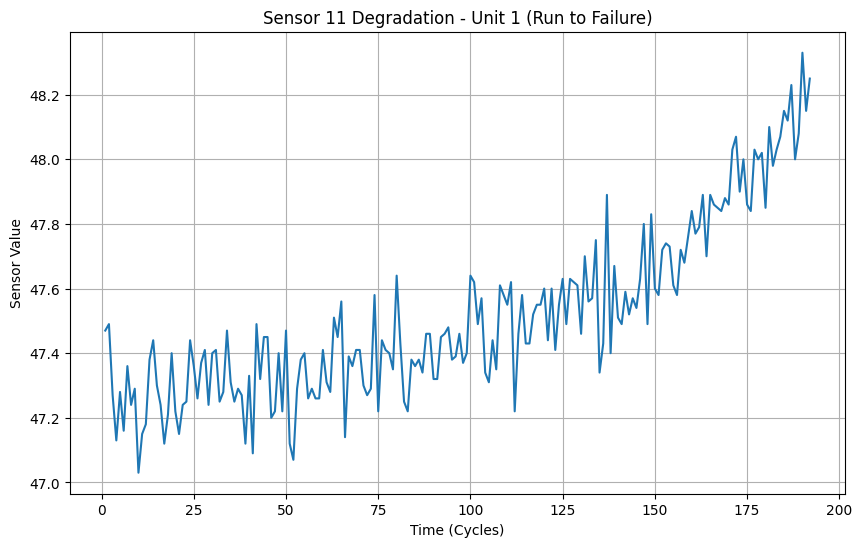

Processed data saved to 'aerosense_processed_data.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Defining the 26 Column Names based on your proposal
# Unit, Time, 3 Settings, 21 Sensors
cols = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3']
cols += [f's_{i}' for i in range(1, 22)]

# 2. Loading the Data (FD001 is the training set)
df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=cols)

print(f"Dataset Loaded. Shape: {df.shape}")
print("First 5 rows:")
print(df.head())

# 3. Engineering Target 1: Remaining Useful Life (RUL)
# For the training set, the max cycle for a unit is its point of failure.
# RUL = Max Cycle - Current Cycle
def add_rul(g):
    g['RUL'] = g['time_cycles'].max() - g['time_cycles']
    return g

df = df.groupby('unit_nr').apply(add_rul)

# 4. Engineering Target 2: Binary Classification Label (Safe vs. Warning)
# We define "Warning" as within 30 cycles of failure.
# 0 = Safe, 1 = Warning
w = 30
df['label_bc'] = df['RUL'].apply(lambda x: 1 if x <= w else 0)

# Checking the new columns
print("\nData with Targets (RUL and label_bc):")
print(df[['unit_nr', 'time_cycles', 'RUL', 'label_bc']].head())

# 5. Exploratory Visualization
# Plotting Sensor 11 (High Pressure Turbine) for Unit 1 to show degradation
plt.figure(figsize=(10, 6))
unit_1 = df[df['unit_nr'] == 1]
plt.plot(unit_1['time_cycles'], unit_1['s_11'])
plt.title('Sensor 11 Degradation - Unit 1 (Run to Failure)')
plt.xlabel('Time (Cycles)')
plt.ylabel('Sensor Value')
plt.grid(True)
plt.show()

# 6. Saving the processed file
df.to_csv('aerosense_processed_data.csv', index=False)
print("Processed data saved to 'aerosense_processed_data.csv'")

### Model 1 (The Deep Learning Classifier)

This model needs to take the sensor data and predict if the engine is "Safe" (0) or in a "Warning State" (1).

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Loading Data (The file we created in the previous step)
df = pd.read_csv('aerosense_processed_data.csv')

# Feature Selection (Drop constant sensors 1, 5, 10, 16, 18, 19 as promised in report)
drop_cols = ['unit_nr', 'time_cycles', 'RUL', 'label_bc',
             's_1', 's_5', 's_10', 's_16', 's_18', 's_19', 'setting_1', 'setting_2', 'setting_3']
features = [c for c in df.columns if c not in drop_cols]
X = df[features]
y = df['label_bc'] # Target: 0 = Safe, 1 = Warning

# Scale Data (Critical for Neural Networks)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Building Deep Learning Model (The Requirement: "From Scratch")
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),              # Prevents overfitting
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid') # Sigmoid for Binary Classification (0 or 1)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training Model
print("Training Deep Learning Classifier...")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluating
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nModel Accuracy: {accuracy*100:.2f}%")

# Saving Results for Tableau (We need predictions to visualize later)
# We will attach predictions back to the original test set
predictions = model.predict(X_test)
results_df = pd.DataFrame(X_test, columns=features)
results_df['True_Label'] = y_test.values
results_df['Predicted_Probability'] = predictions
results_df['Predicted_Label'] = (predictions > 0.5).astype(int)

results_df.to_csv('tableau_classification_results.csv', index=False)
print("Results saved to 'tableau_classification_results.csv'")

# Saving the model file itself
model.save('aerosense_classifier_model.h5')
print("Model saved as 'aerosense_classifier_model.h5'")

Training Deep Learning Classifier...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8726 - loss: 0.2856 - val_accuracy: 0.9582 - val_loss: 0.1092
Epoch 2/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9552 - loss: 0.1085 - val_accuracy: 0.9588 - val_loss: 0.1091
Epoch 3/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9572 - loss: 0.1086 - val_accuracy: 0.9552 - val_loss: 0.1046
Epoch 4/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9527 - loss: 0.1120 - val_accuracy: 0.9558 - val_loss: 0.1037
Epoch 5/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9556 - loss: 0.1066 - val_accuracy: 0.9564 - val_loss: 0.1022
Epoch 6/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9578 - loss: 0.0996 - val_accuracy: 0.9606 - val_loss: 0.1008
Epoch 7/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9593 - loss: 0.0960 - val_accuracy: 0.9546 - val_loss: 0.1012
Epoch 8/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9589 - loss: 0.0975 - val_accuracy: 0.9600 - val_

Results saved to 'tableau_classification_results.csv'
Model saved as 'aerosense_classifier_model.h5'


### Model 2: Time Series Prediction (LSTM).

Data Shape: (15631, 50, 15)
Label Shape: (15631, 1)
Training LSTM Time Series Predictor...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - loss: 9673.2197 - val_loss: 8435.2598
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - loss: 8348.7158 - val_loss: 7793.7578
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - loss: 7894.1191 - val_loss: 7269.2969
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step - loss: 7256.1514 - val_loss: 6808.2310
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step - loss: 6735.9814 - val_loss: 6389.6177
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - loss: 6399.4072 - val_loss: 6013.7847
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - loss: 6004.8511 - val_loss: 5674.8096
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - loss: 5777.8740 - val_loss: 5366.3662
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - loss: 5308.1167 - val_loss: 5090.0581
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - loss: 5217.3735 - val_loss: 4840.3755


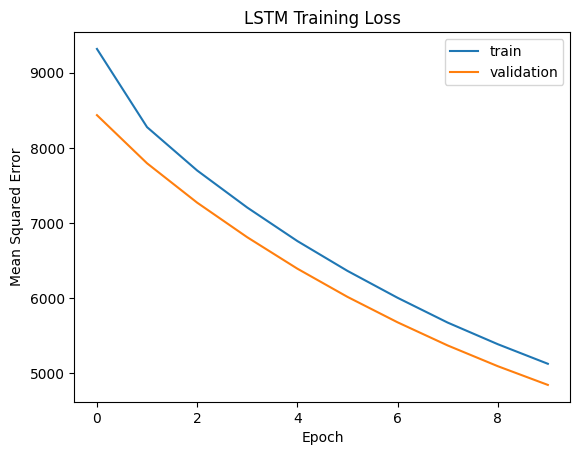

489/489 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step
Results saved to 'tableau_rul_results.csv'


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

feature_cols = [c for c in df.columns if c not in drop_cols]

# Sequence Generation (The Critical "Windowing" Step)
# LSTMs need to look back at history. We will look at the last 50 cycles to predict the RUL.
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# Generate sequences for each engine unit
# Note: We can only use units that have at least 50 cycles of history
seq_gen = (list(gen_sequence(df[df['unit_nr']==id], sequence_length, feature_cols))
           for id in df['unit_nr'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# Generating Labels (Target: RUL)
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

label_gen = (gen_labels(df[df['unit_nr']==id], sequence_length, ['RUL'])
             for id in df['unit_nr'].unique())
label_array = np.concatenate(list(label_gen)).astype(np.float32)

print(f"Data Shape: {seq_array.shape}") # Should be (Samples, 50, Features)
print(f"Label Shape: {label_array.shape}")

# Building the LSTM Model
model = Sequential([
    # Input shape is (50 time steps, number of features)
    LSTM(100, input_shape=(seq_array.shape[1], seq_array.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear') # Linear activation for Regression (Predicting a number)
])

model.compile(loss='mean_squared_error', optimizer='adam')

# Training the Model
print("Training LSTM Time Series Predictor...")
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1)

# Visualizing Training History (Good for your Report)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM Training Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Saving Model & Results for Tableau
model.save('aerosense_rul_lstm.h5')

# Making predictions on the training set just to visualize in Tableau
train_pred = model.predict(seq_array)
results_df = pd.DataFrame(label_array, columns=['True_RUL'])
results_df['Predicted_RUL'] = train_pred

# Saving to CSV
results_df.to_csv('tableau_rul_results.csv', index=False)
print("Results saved to 'tableau_rul_results.csv'")